In [64]:
import pandas as pd
import os

# Load the master dataframe
df_10k = pd.read_csv('../data/askme-qa/raw_data_10k.csv')

# Directory structure
base_dir = '../data/hitl'
annotators = ['HITL_Alex', 'HITL_Atheer', 'HITL_Hend', 'HITL_Xiaoyuan']
file_names = ['Copy of answers_samples.xlsx', 'Copy of questions_samples.xlsx', 'Copy of questions_zs_samples.xlsx']

# Initialize empty DataFrames for each type of samples
df_answers = None
df_questions = None
df_questions_zs = None

# Iterate over each annotator and each file
for annotator in annotators:
    for file_name in file_names:
        file_path = os.path.join(base_dir, annotator, file_name)
        df = pd.read_excel(file_path)

        # Drop "instructions" column and unnamed columns
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
        if 'instructions' in df.columns:
            df = df.drop(columns=['instructions'])
        if 'Comments' in df.columns:
            df = df.drop(columns=['Comments'])
        # Drop columns with names that are not in English
        df = df.drop(columns=[col for col in df.columns if not col.isascii()])

        # Rename "annotation" column to include the annotator's name
        if 'annotation' in df.columns:
            annotator_name = annotator.split('_')[-1].lower()
            df = df.rename(columns={'annotation': f'annotation_{annotator_name}'})
            annotation_col = df[[f'annotation_{annotator_name}']]  # Select only the renamed annotation column

            # Merge data to respective DataFrames horizontally
            if 'answers' in file_name:
                if df_answers is None:
                    df_answers = df[['answer_id']].join(annotation_col)
                else:
                    df_answers = df_answers.join(annotation_col, rsuffix=f'_{annotator_name}')
            elif 'questions_zs' in file_name:
                if df_questions_zs is None:
                    df_questions_zs = df[['question_id']].join(annotation_col)
                else:
                    df_questions_zs = df_questions_zs.join(annotation_col, rsuffix=f'_{annotator_name}')
            else:  # 'questions' in file_name
                if df_questions is None:
                    df_questions = df[['question_id']].join(annotation_col)
                else:
                    df_questions = df_questions.join(annotation_col, rsuffix=f'_{annotator_name}')

# Filter the master dataframe for the specific settings
df_10k_ic = df_10k[df_10k['setting'] == 'ic']
df_10k_zs = df_10k[df_10k['setting'] == 'zs']

# Append additional fields from df_10k
df_answers = df_answers.merge(df_10k[['id_answer', 'value']], left_on='answer_id', right_on='id_answer', how='left').drop(columns=['id_answer'])
df_questions_zs = df_questions_zs.merge(df_10k_zs[['question_id', 'is_answerable_zs']], on='question_id', how='left')
df_questions = df_questions.merge(df_10k_ic[['question_id', 'is_answerable_ic']], on='question_id', how='left')

# Rename columns
df_questions = df_questions.rename(columns={'is_answerable_ic': 'annotation_llama3_70b'})
df_questions_zs = df_questions_zs.rename(columns={'is_answerable_zs': 'annotation_llama3_70b'})
df_answers = df_answers.rename(columns={'value': 'annotation_llama3_70b'})

# Replace Y with True and N with False for all annotation columns
for col in df_questions.columns:
    if col.startswith('annotation_'):
        df_questions[col] = df_questions[col].replace({'Y': True, 'N': False})
for col in df_questions_zs.columns:
    if col.startswith('annotation_'):
        df_questions_zs[col] = df_questions_zs[col].replace({'Y': True, 'N': False})
for col in df_answers.columns:
    if col.startswith('annotation_'):
        df_answers[col] = df_answers[col].replace({'Y': True, 'N': False})

# Save the updated DataFrames to CSV files
df_questions.to_csv('../data/hitl/questions.csv', index=False)
df_questions_zs.to_csv('../data/hitl/questions_zs.csv', index=False)
df_answers.to_csv('../data/hitl/answers.csv', index=False)


In [65]:
df_questions

,question_id,annotation_alex,annotation_atheer,annotation_hend,annotation_xiaoyuan,annotation_llama3_70b
0,36261,True,NaN,True,True,True
1,39026,True,NaN,True,True,True
2,4635,True,NaN,True,True,True
3,39011,True,NaN,True,True,True
4,27424,True,NaN,True,True,True
...,...,...,...,...,...,...
95,37261,True,True,NaN,True,True
96,17660,True,True,NaN,True,True
97,3509,False,True,NaN,False,True
98,2839,True,False,NaN,True,True


In [66]:
# Function to calculate average correlation between human annotators
def average_human_correlation(df):
    annotator_columns = [col for col in df.columns if col.startswith('annotation_') and col != 'annotation_llama3_70b']
    n = len(annotator_columns)
    correlations = []

    for i in range(n):
        for j in range(i + 1, n):
            common_data = df[[annotator_columns[i], annotator_columns[j]]].dropna()
            if not common_data.empty and common_data[annotator_columns[i]].nunique() > 1 and common_data[annotator_columns[j]].nunique() > 1:
                corr, _ = pearsonr(common_data[annotator_columns[i]], common_data[annotator_columns[j]])
                correlations.append(corr)
            elif common_data[annotator_columns[i]].nunique() == 1 and common_data[annotator_columns[j]].nunique() == 1:
                if common_data[annotator_columns[i]].unique()[0] == common_data[annotator_columns[j]].unique()[0]:
                    correlations.append(1)
                else:
                    correlations.append(-1)

    return sum(correlations) / len(correlations) if correlations else 0

# Function to calculate average correlation between human annotators and machine annotator
def average_human_machine_correlation(df):
    human_columns = [col for col in df.columns if col.startswith('annotation_') and col != 'annotation_llama3_70b']
    machine_column = 'annotation_llama3_70b'
    correlations = []

    for human_col in human_columns:
        common_data = df[[human_col, machine_column]].dropna()
        if not common_data.empty and common_data[human_col].nunique() > 1 and common_data[machine_column].nunique() > 1:
            corr, _ = pearsonr(common_data[human_col], common_data[machine_column])
            correlations.append(corr)
        elif common_data[human_col].nunique() == 1 and common_data[machine_column].nunique() == 1:
            if common_data[human_col].unique()[0] == common_data[machine_column].unique()[0]:
                correlations.append(1)
            else:
                correlations.append(-1)


    return sum(correlations) / len(correlations) if correlations else 0

# Calculate correlations for each type of sample
avg_human_corr_answers = average_human_correlation(df_answers)
avg_human_machine_corr_answers = average_human_machine_correlation(df_answers)

avg_human_corr_questions = average_human_correlation(df_questions)
avg_human_machine_corr_questions = average_human_machine_correlation(df_questions)

avg_human_corr_questions_zs = average_human_correlation(df_questions_zs)
avg_human_machine_corr_questions_zs = average_human_machine_correlation(df_questions_zs)

# Print the results
print("Average Human Correlation for Answers:", avg_human_corr_answers)
print("Average Human-Machine Correlation for Answers:", avg_human_machine_corr_answers)

print("Average Human Correlation for Questions:", avg_human_corr_questions)
print("Average Human-Machine Correlation for Questions:", avg_human_machine_corr_questions)

print("Average Human Correlation for Questions ZS:", avg_human_corr_questions_zs)
print("Average Human-Machine Correlation for Questions ZS:", avg_human_machine_corr_questions_zs)


Average Human Correlation for Answers: 0.8478551624991684
Average Human-Machine Correlation for Answers: 0.7673632264273624
Average Human Correlation for Questions: 0.09792867290069802
Average Human-Machine Correlation for Questions: 0.04429664173956865
Average Human Correlation for Questions ZS: 0.346574014693432
Average Human-Machine Correlation for Questions ZS: 0.2986643420521499


In [67]:
def average_human_correlation(df):
    annotator_columns = [col for col in df.columns if col.startswith('annotation_') and col != 'annotation_llama3_70b']
    n = len(annotator_columns)
    correlations = []
    overlaps = []

    for i in range(n):
        for j in range(i + 1, n):
            common_data = df[[annotator_columns[i], annotator_columns[j]]].dropna()
            overlap = len(common_data)
            overlaps.append(overlap)
            if not common_data.empty and common_data[annotator_columns[i]].nunique() > 1 and common_data[annotator_columns[j]].nunique() > 1:
                corr, _ = pearsonr(common_data[annotator_columns[i]].astype(float), common_data[annotator_columns[j]].astype(float))
                correlations.append(corr)

    average_overlap = sum(overlaps) / len(overlaps) if overlaps else 0
    return (sum(correlations) / len(correlations) if correlations else 0), average_overlap

# Function to calculate average correlation between human annotators and machine annotator
def average_human_machine_correlation(df):
    human_columns = [col for col in df.columns if col.startswith('annotation_') and col != 'annotation_llama3_70b']
    machine_column = 'annotation_llama3_70b'
    correlations = []
    overlaps = []

    for human_col in human_columns:
        common_data = df[[human_col, machine_column]].dropna()
        overlap = len(common_data)
        overlaps.append(overlap)
        if not common_data.empty and common_data[human_col].nunique() > 1 and common_data[machine_column].nunique() > 1:
            corr, _ = pearsonr(common_data[human_col].astype(float), common_data[machine_column].astype(float))
            correlations.append(corr)

    average_overlap = sum(overlaps) / len(overlaps) if overlaps else 0
    return (sum(correlations) / len(correlations) if correlations else 0), average_overlap

# Calculate correlations for each type of sample
avg_human_corr_answers, avg_overlap_answers = average_human_correlation(df_answers)
avg_human_machine_corr_answers, avg_overlap_machine_answers = average_human_machine_correlation(df_answers)

avg_human_corr_questions, avg_overlap_questions = average_human_correlation(df_questions)
avg_human_machine_corr_questions, avg_overlap_machine_questions = average_human_machine_correlation(df_questions)

avg_human_corr_questions_zs, avg_overlap_questions_zs = average_human_correlation(df_questions_zs)
avg_human_machine_corr_questions_zs, avg_overlap_machine_questions_zs = average_human_machine_correlation(df_questions_zs)

# Print the results
print("Average Human Correlation for Answers:", avg_human_corr_answers)
print("Average Human-Machine Correlation for Answers:", avg_human_machine_corr_answers)
print("Average Overlap for Answers:", avg_overlap_answers)
print("Average Overlap Human-Machine for Answers:", avg_overlap_machine_answers)
print()
print("Average Human Correlation for Questions:", avg_human_corr_questions)
print("Average Human-Machine Correlation for Questions:", avg_human_machine_corr_questions)
print("Average Overlap for Questions:", avg_overlap_questions)
print("Average Overlap Human-Machine for Questions:", avg_overlap_machine_questions)
print()
print("Average Human Correlation for Questions ZS:", avg_human_corr_questions_zs)
print("Average Human-Machine Correlation for Questions ZS:", avg_human_machine_corr_questions_zs)
print("Average Overlap for Questions ZS:", avg_overlap_questions_zs)
print("Average Overlap Human-Machine for Questions ZS:", avg_overlap_machine_questions_zs)


Average Human Correlation for Answers: 0.8478551624991684
Average Human-Machine Correlation for Answers: 0.7673632264273624
Average Overlap for Answers: 50.0
Average Overlap Human-Machine for Answers: 75.0

Average Human Correlation for Questions: 0.09792867290069802
Average Human-Machine Correlation for Questions: 0.04429664173956865
Average Overlap for Questions: 50.0
Average Overlap Human-Machine for Questions: 75.0

Average Human Correlation for Questions ZS: 0.346574014693432
Average Human-Machine Correlation for Questions ZS: 0.2986643420521499
Average Overlap for Questions ZS: 50.0
Average Overlap Human-Machine for Questions ZS: 75.0


In [69]:
def agreement_ratio_human(df):
    annotator_columns = [col for col in df.columns if col.startswith('annotation_') and col != 'annotation_llama3_70b']
    n = len(annotator_columns)
    agreements = []
    overlaps = []

    for i in range(n):
        for j in range(i + 1, n):
            common_data = df[[annotator_columns[i], annotator_columns[j]]].dropna()
            overlap = len(common_data)
            overlaps.append(overlap)
            if not common_data.empty:
                agreement = (common_data[annotator_columns[i]] == common_data[annotator_columns[j]]).mean()
                agreements.append(agreement)

    average_overlap = sum(overlaps) / len(overlaps) if overlaps else 0
    return (sum(agreements) / len(agreements) if agreements else 0), average_overlap

# Function to calculate agreement ratio between human annotators and machine annotator
def agreement_ratio_human_machine(df):
    human_columns = [col for col in df.columns if col.startswith('annotation_') and col != 'annotation_llama3_70b']
    machine_column = 'annotation_llama3_70b'
    agreements = []
    overlaps = []

    for human_col in human_columns:
        common_data = df[[human_col, machine_column]].dropna()
        overlap = len(common_data)
        overlaps.append(overlap)
        if not common_data.empty:
            agreement = (common_data[human_col] == common_data[machine_column]).mean()
            agreements.append(agreement)

    average_overlap = sum(overlaps) / len(overlaps) if overlaps else 0
    return (sum(agreements) / len(agreements) if agreements else 0), average_overlap

# Calculate agreement ratios for each type of sample
agreement_human_answers, overlap_human_answers = agreement_ratio_human(df_answers)
agreement_human_machine_answers, overlap_human_machine_answers = agreement_ratio_human_machine(df_answers)

agreement_human_questions, overlap_human_questions = agreement_ratio_human(df_questions)
agreement_human_machine_questions, overlap_human_machine_questions = agreement_ratio_human_machine(df_questions)

agreement_human_questions_zs, overlap_human_questions_zs = agreement_ratio_human(df_questions_zs)
agreement_human_machine_questions_zs, overlap_human_machine_questions_zs = agreement_ratio_human_machine(df_questions_zs)

# Print the results
print("Human Agreement Ratio for Answers:", agreement_human_answers)
print("Human-Machine Agreement Ratio for Answers:", agreement_human_machine_answers)
print("Overlap for Answers:", overlap_human_answers)
print("Overlap Human-Machine for Answers:", overlap_human_machine_answers)
print()
print("Human Agreement Ratio for Questions:", agreement_human_questions)
print("Human-Machine Agreement Ratio for Questions:", agreement_human_machine_questions)
print("Overlap for Questions:", overlap_human_questions)
print("Overlap Human-Machine for Questions:", overlap_human_machine_questions)
print()
print("Human Agreement Ratio for Questions ZS:", agreement_human_questions_zs)
print("Human-Machine Agreement Ratio for Questions ZS:", agreement_human_machine_questions_zs)
print("Overlap for Questions ZS:", overlap_human_questions_zs)
print("Overlap Human-Machine for Questions ZS:", overlap_human_machine_questions_zs)

Human Agreement Ratio for Answers: 0.6033333333333334
Human-Machine Agreement Ratio for Answers: 0.5466666666666667
Overlap for Answers: 50.0
Overlap Human-Machine for Answers: 75.0

Human Agreement Ratio for Questions: 0.7999999999999999
Human-Machine Agreement Ratio for Questions: 0.8866666666666667
Overlap for Questions: 50.0
Overlap Human-Machine for Questions: 75.0

Human Agreement Ratio for Questions ZS: 0.8333333333333334
Human-Machine Agreement Ratio for Questions ZS: 0.5333333333333333
Overlap for Questions ZS: 50.0
Overlap Human-Machine for Questions ZS: 75.0


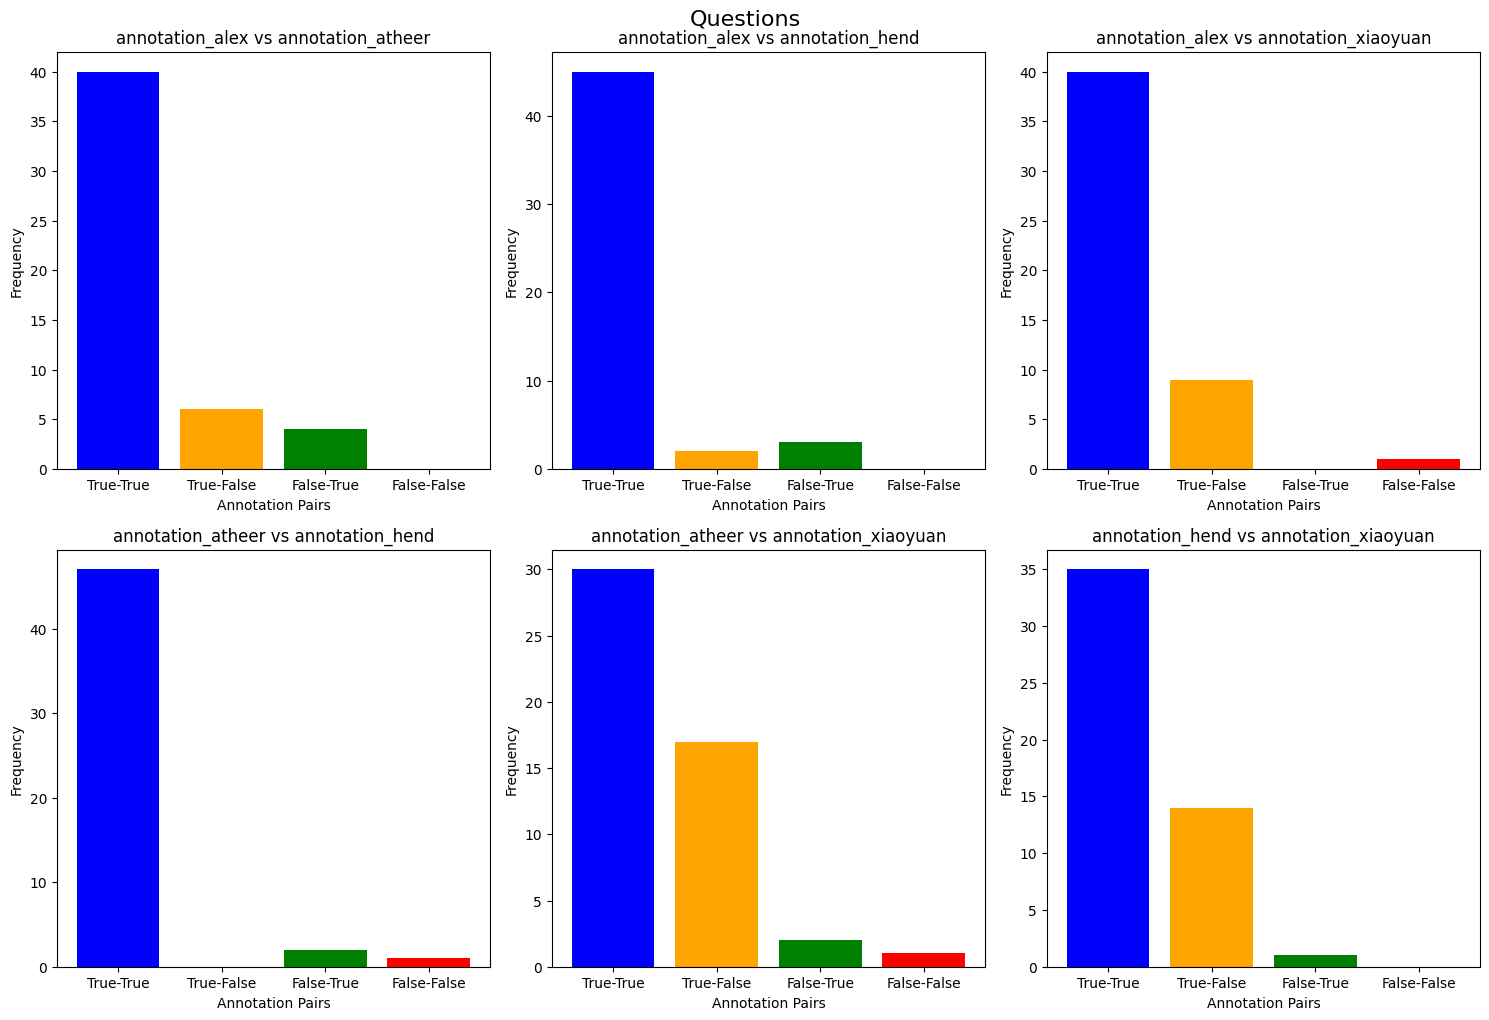

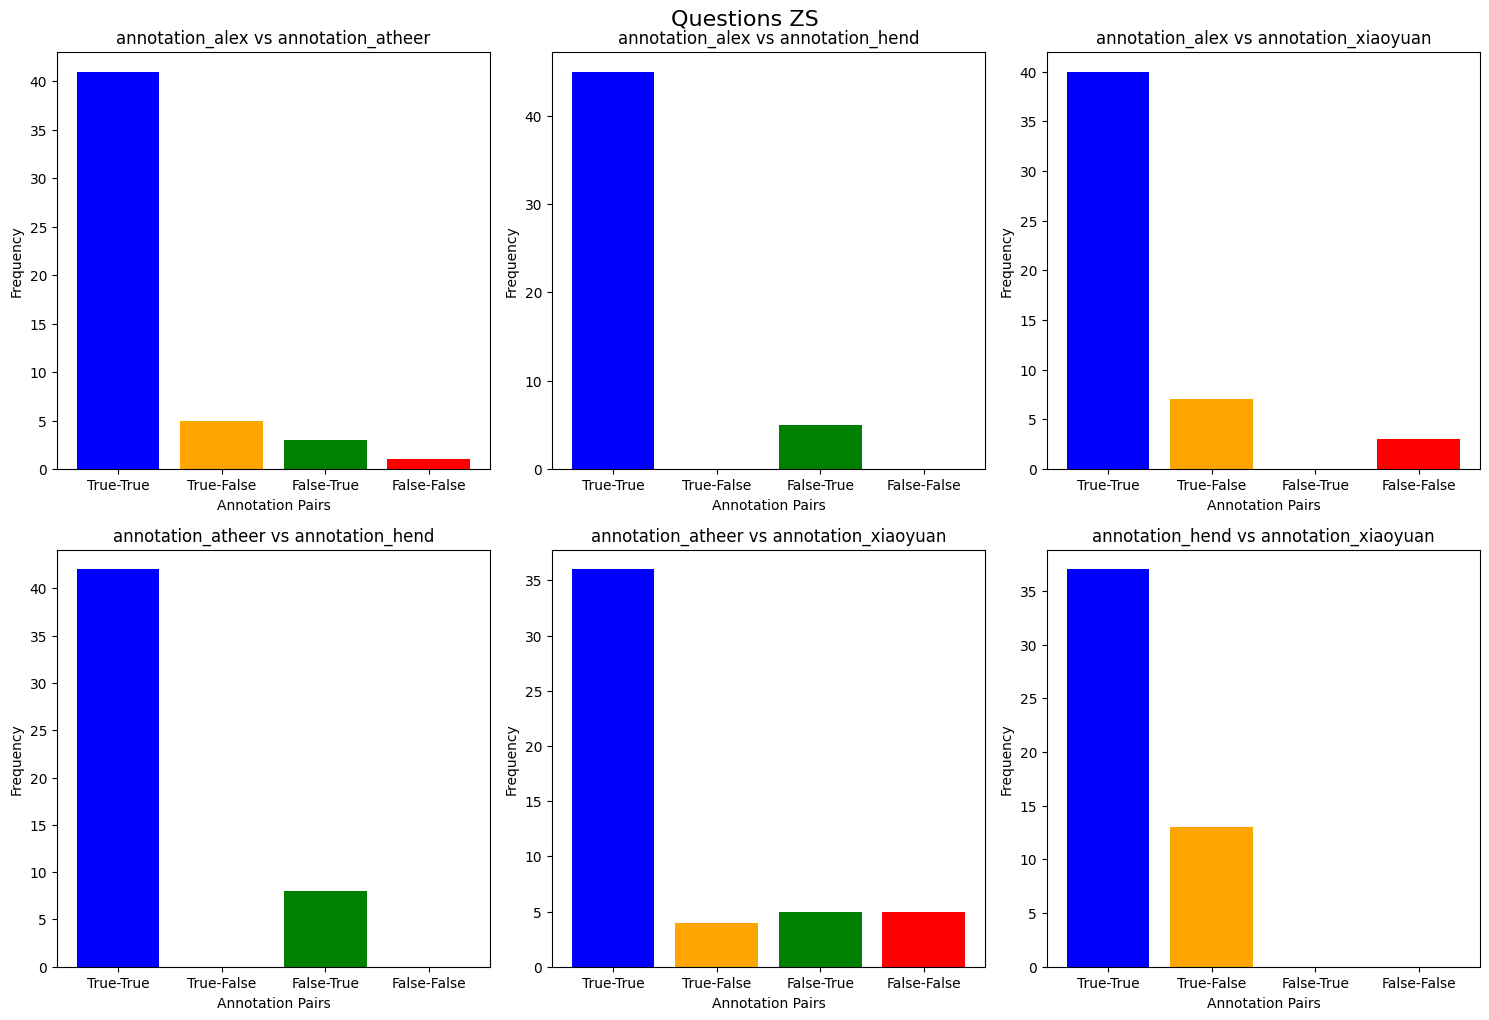

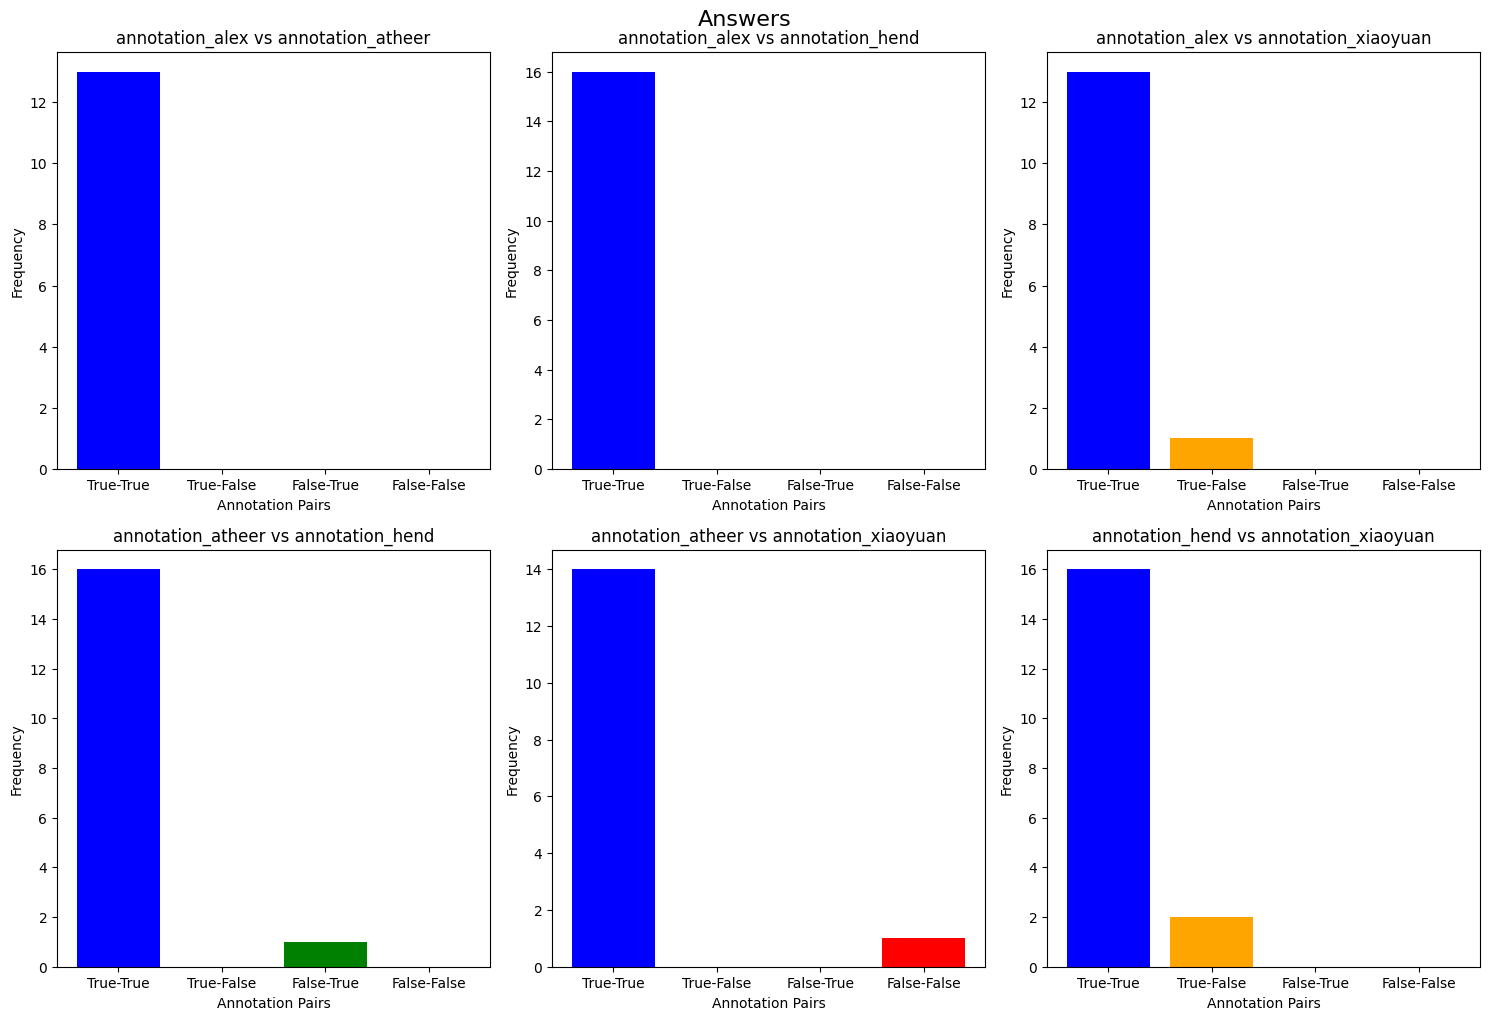

In [74]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from itertools import combinations

# Function to plot annotator's frequencies against other annotators in a grid
def plot_annotator_frequencies_grid(df, title):
    annotator_columns = [col for col in df.columns if col.startswith('annotation_') and col != 'annotation_llama3_70b']
    pairs = list(combinations(annotator_columns, 2))
    n_pairs = len(pairs)
    grid_size = int(n_pairs ** 0.5) + (n_pairs % int(n_pairs ** 0.5) > 0) + 1

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axes = axes.flatten()

    for i, (annotator1, annotator2) in enumerate(pairs):
        data = df[[annotator1, annotator2]].dropna()
        true_true = len(data[(data[annotator1] == True) & (data[annotator2] == True)])
        true_false = len(data[(data[annotator1] == True) & (data[annotator2] == False)])
        false_true = len(data[(data[annotator1] == False) & (data[annotator2] == True)])
        false_false = len(data[(data[annotator1] == False) & (data[annotator2] == False)])

        labels = ['True-True', 'True-False', 'False-True', 'False-False']
        counts = [true_true, true_false, false_true, false_false]

        axes[i].bar(labels, counts, color=['blue', 'orange', 'green', 'red'])
        axes[i].set_title(f'{annotator1} vs {annotator2}')
        axes[i].set_xlabel('Annotation Pairs')
        axes[i].set_ylabel('Frequency')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot the frequencies in a grid for each DataFrame
plot_annotator_frequencies_grid(df_questions, "Questions")
plot_annotator_frequencies_grid(df_questions_zs, "Questions ZS")
plot_annotator_frequencies_grid(df_answers, "Answers")

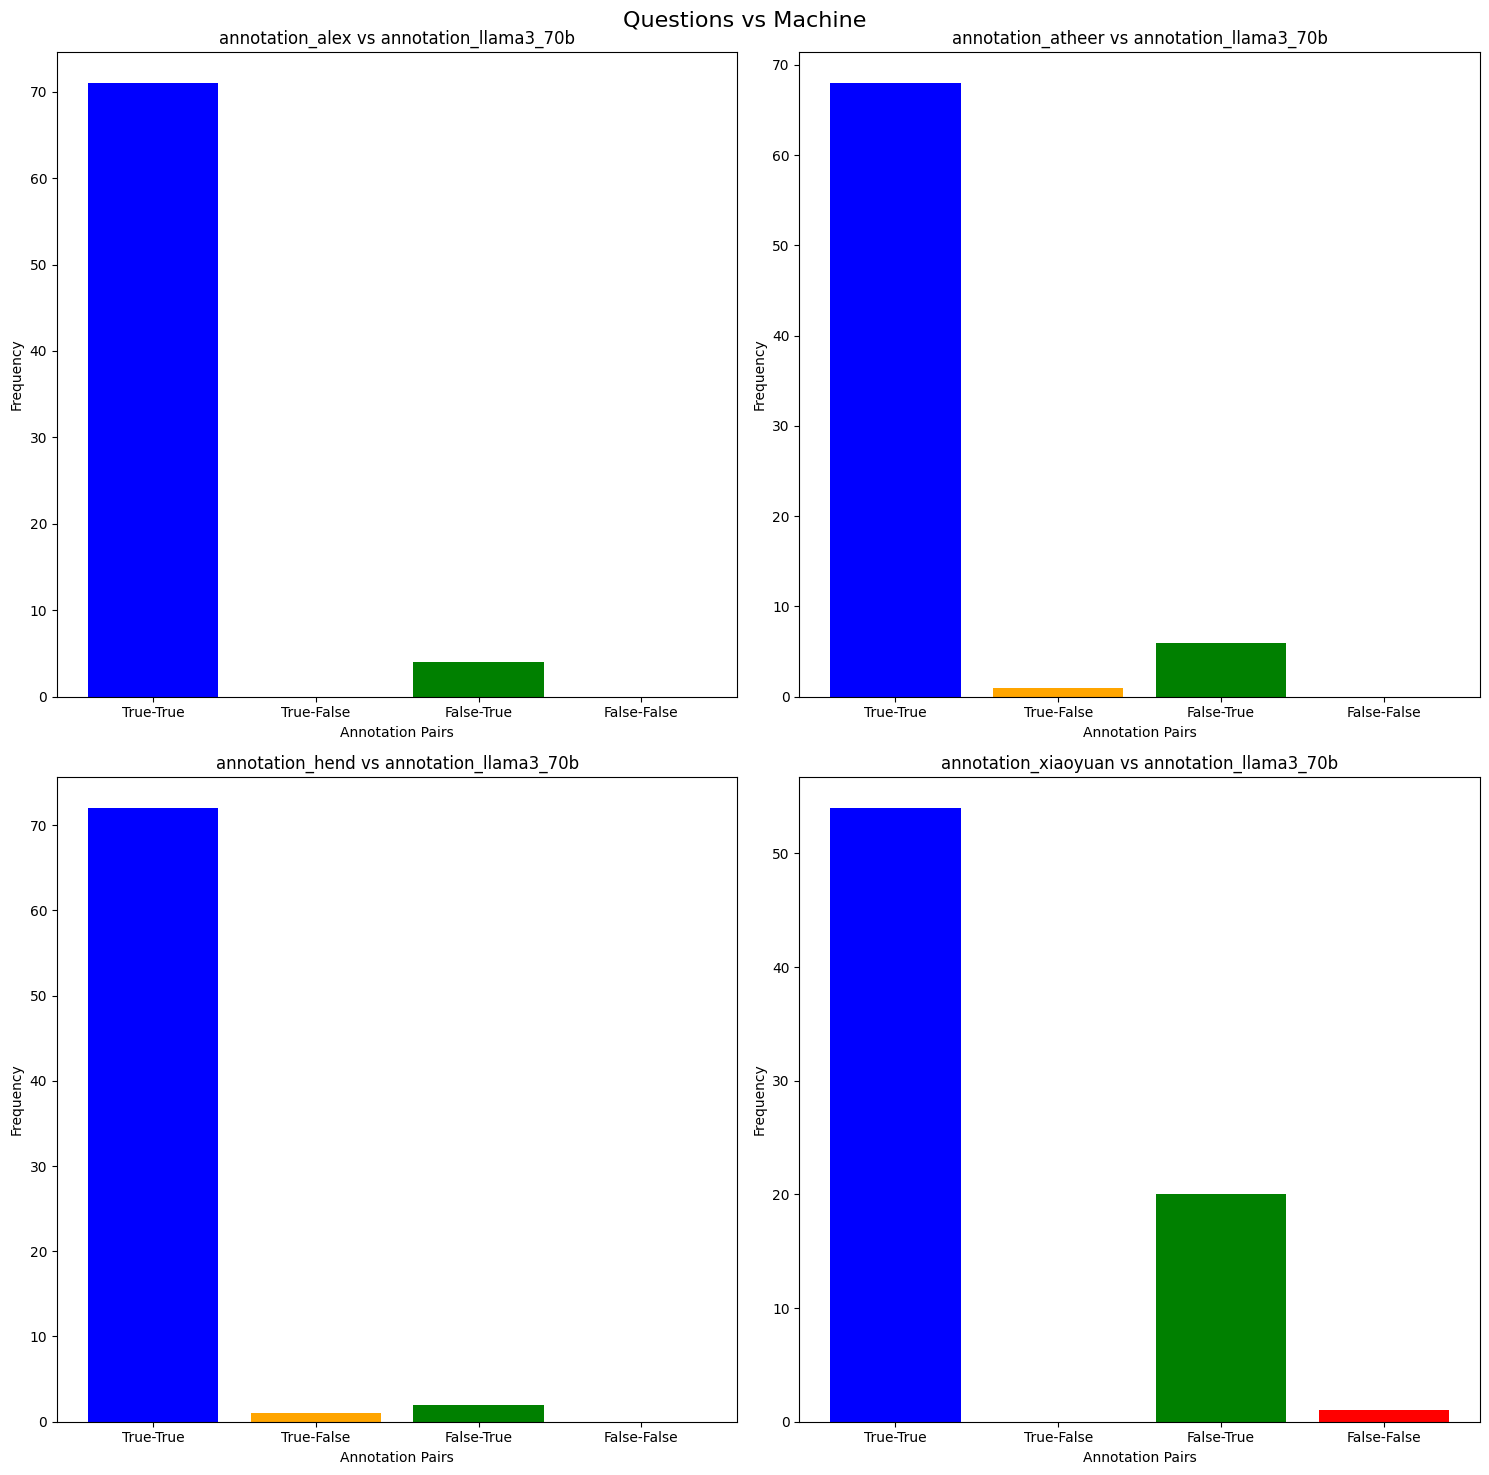

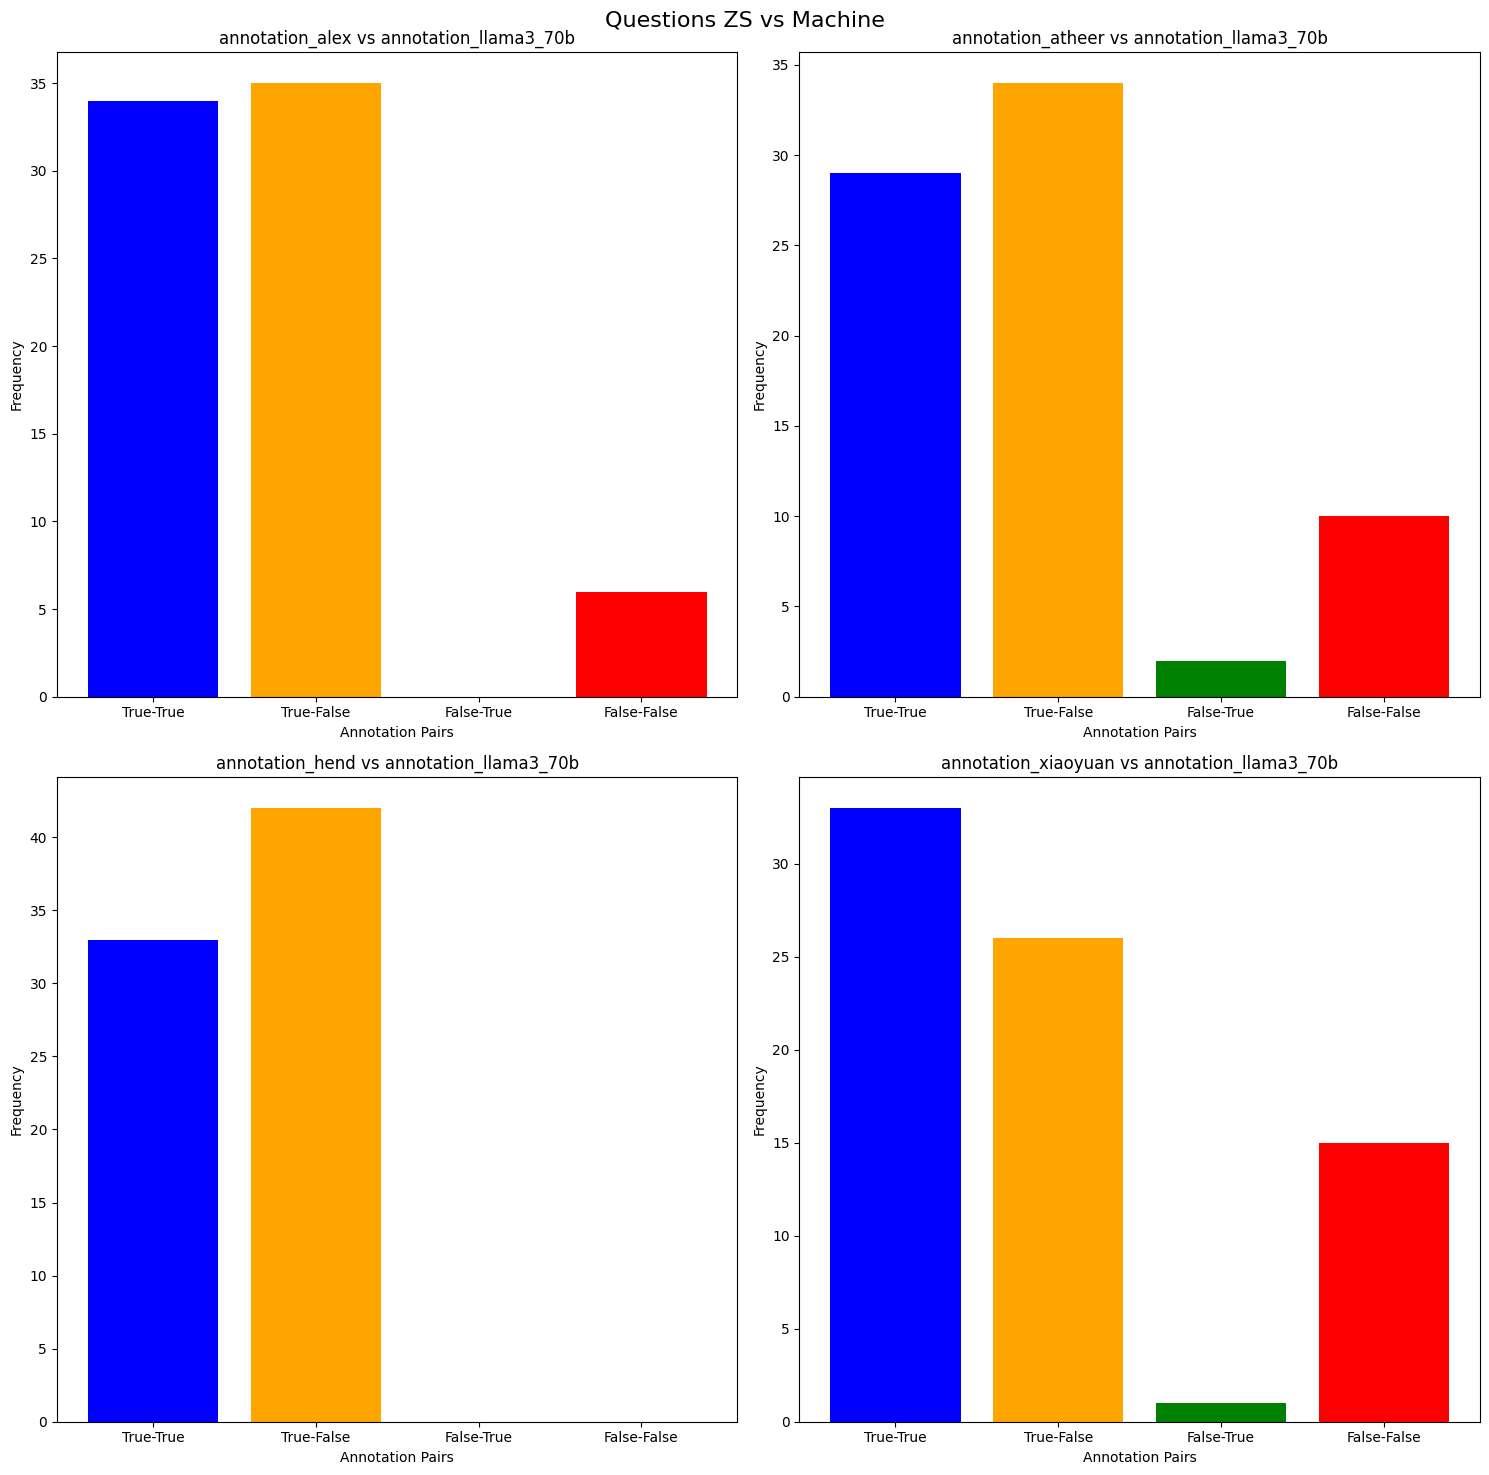

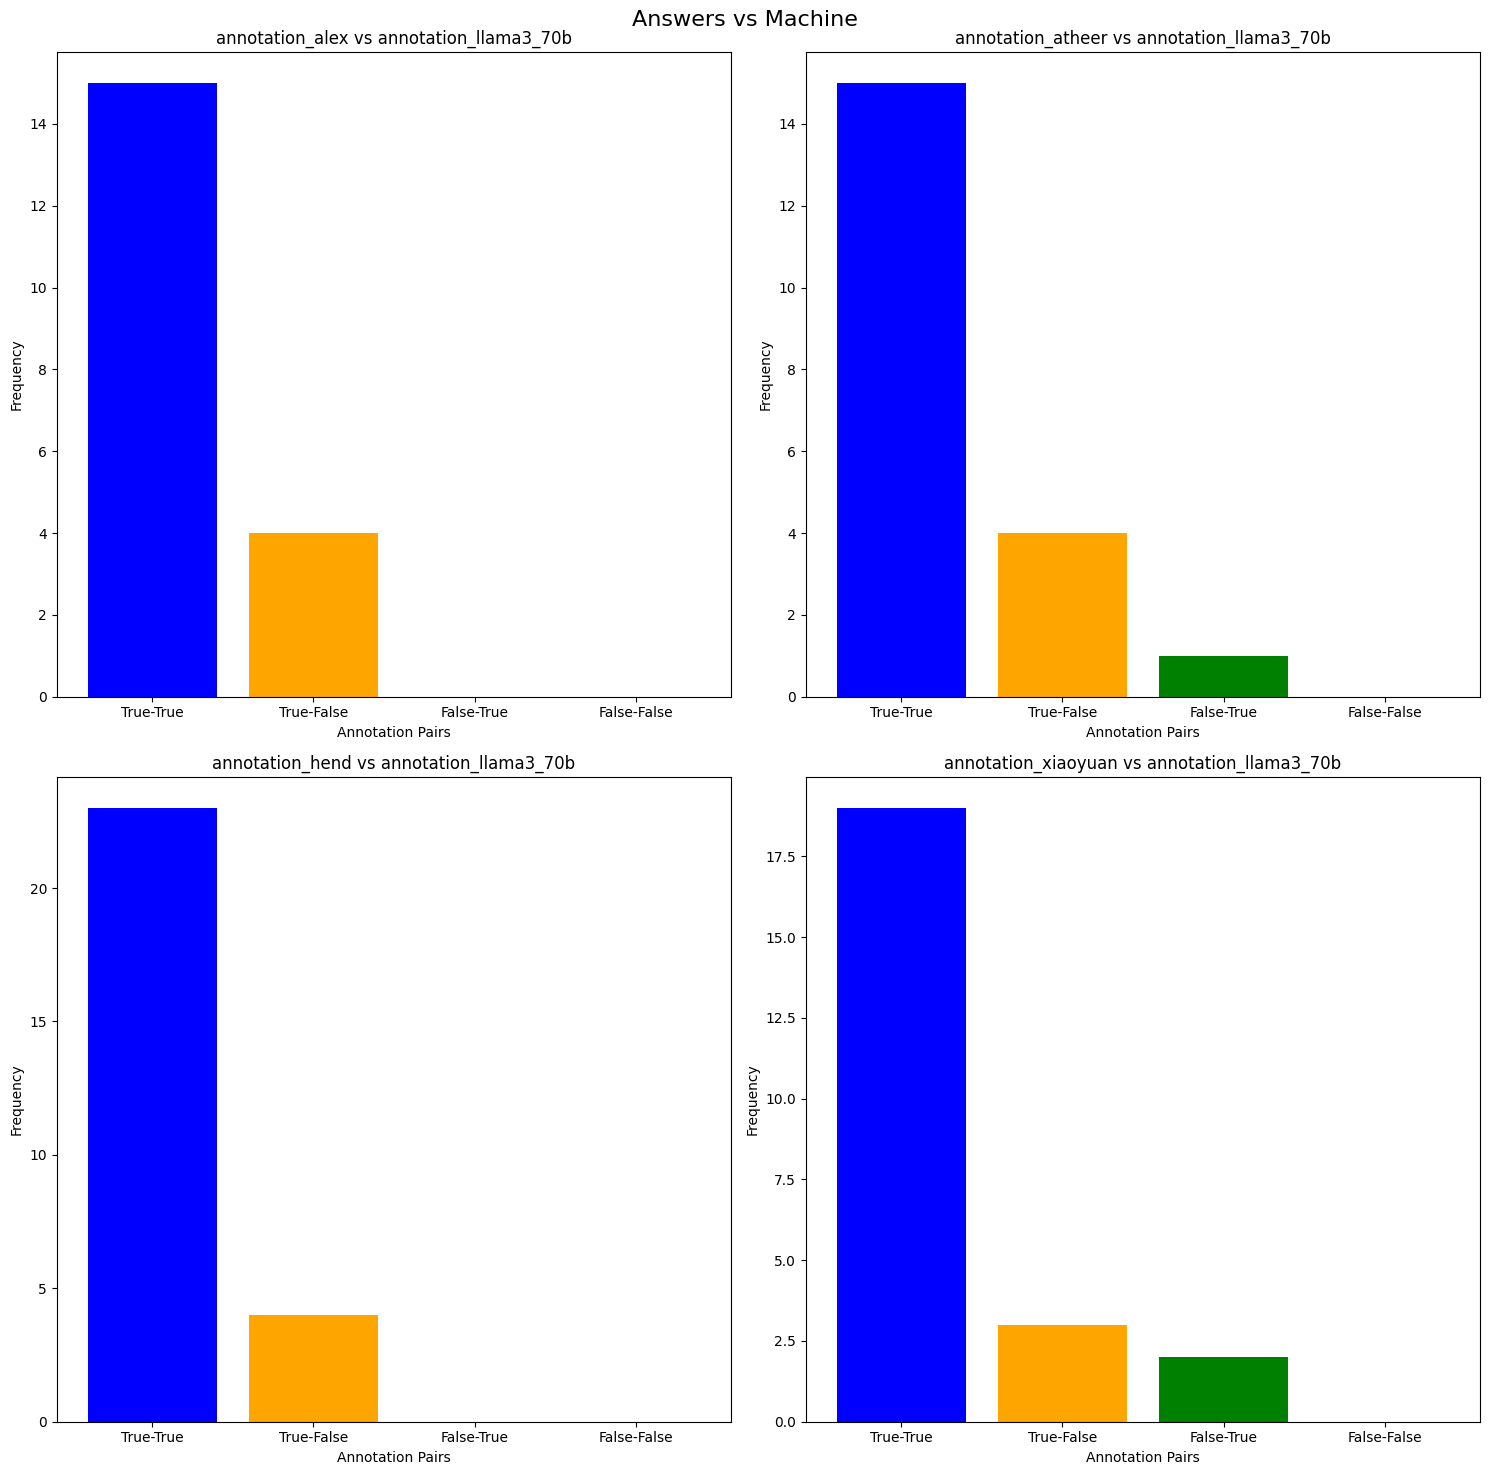

In [75]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from itertools import combinations

# Function to plot annotator's frequencies against the machine annotator in a grid
def plot_annotator_vs_machine_frequencies_grid(df, title):
    annotator_columns = [col for col in df.columns if col.startswith('annotation_') and col != 'annotation_llama3_70b']
    machine_column = 'annotation_llama3_70b'
    n_annotators = len(annotator_columns)
    grid_size = int(n_annotators ** 0.5) + (n_annotators % int(n_annotators ** 0.5) > 0)

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axes = axes.flatten()

    for i, annotator in enumerate(annotator_columns):
        data = df[[annotator, machine_column]].dropna()
        true_true = len(data[(data[annotator] == True) & (data[machine_column] == True)])
        true_false = len(data[(data[annotator] == True) & (data[machine_column] == False)])
        false_true = len(data[(data[annotator] == False) & (data[machine_column] == True)])
        false_false = len(data[(data[annotator] == False) & (data[machine_column] == False)])

        labels = ['True-True', 'True-False', 'False-True', 'False-False']
        counts = [true_true, true_false, false_true, false_false]

        axes[i].bar(labels, counts, color=['blue', 'orange', 'green', 'red'])
        axes[i].set_title(f'{annotator} vs {machine_column}')
        axes[i].set_xlabel('Annotation Pairs')
        axes[i].set_ylabel('Frequency')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot the frequencies in a grid for each DataFrame
plot_annotator_vs_machine_frequencies_grid(df_questions, "Questions vs Machine")
plot_annotator_vs_machine_frequencies_grid(df_questions_zs, "Questions ZS vs Machine")
plot_annotator_vs_machine_frequencies_grid(df_answers, "Answers vs Machine")
